# Models Training (CIELAB) File

# 1. Import modules

In [16]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble, svm, neural_network
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 2. Define functions

In [17]:
# Method to convert RGB to CIELAB
def rgb_to_lab(r, g, b):
    # Gamma correction
    rgb = [c / 255.0 for c in [r, g, b]]
    for i in range(3):
        if rgb[i] <= 0.04045:
            rgb[i] /= 12.92
        else:
            rgb[i] = ((rgb[i] + 0.055) / 1.055) ** 2.4

    # RGB to CIEXYZ
    X = 0.4124 * rgb[0] + 0.3576 * rgb[1] + 0.1805 * rgb[2]
    Y = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    Z = 0.0193 * rgb[0] + 0.1192 * rgb[1] + 0.9505 * rgb[2]

    # Normalize for D65 illuminant
    X /= 0.95047
    Y /= 1.00000
    Z /= 1.08883

    X_trans = X ** (1/3) if X > 0.008856 else 7.787 * X + 16/116
    Y_trans = Y ** (1/3) if Y > 0.008856 else 7.787 * Y + 16/116
    Z_trans = Z ** (1/3) if Z > 0.008856 else 7.787 * Z + 16/116

    L = 116.0 * Y_trans - 16.0
    a = 500.0 * (X_trans - Y_trans)
    b = 200.0 * (Y_trans - Z_trans)

    return L, a, b

# Method to convert CIELAB to RGB
def lab_to_rgb(L, a, b):
    # CIELAB to CIEXYZ
    Y = (L + 16) / 116
    X = a / 500 + Y
    Z = Y - b / 200
    
    if Y**3 > 0.008856:
        Y = Y**3
    else:
        Y = (Y - 16/116) / 7.787
    
    if X**3 > 0.008856:
        X = X**3
    else:
        X = (X - 16/116) / 7.787
        
    if Z**3 > 0.008856:
        Z = Z**3
    else:
        Z = (Z - 16/116) / 7.787
        
    # D65 illuminant
    X = X * 0.95047
    Y = Y * 1.00000
    Z = Z * 1.08883
    
    # CIEXYZ to linear RGB
    r = X *  3.2406 + Y * -1.5372 + Z * -0.4986
    g = X * -0.9689 + Y *  1.8758 + Z *  0.0415
    b = X *  0.0557 + Y * -0.2040 + Z *  1.0570
    
    # Apply gamma correction on linear RGB values
    if r > 0.0031308:
        r = 1.055 * (r**(1/2.4)) - 0.055
    else:
        r = 12.92 * r
        
    if g > 0.0031308:
        g = 1.055 * (g**(1/2.4)) - 0.055
    else:
        g = 12.92 * g
        
    if b > 0.0031308:
        b = 1.055 * (b**(1/2.4)) - 0.055
    else:
        b = 12.92 * b
        
    # Convert these values to the range [0, 255]
    r = min(max(int(r * 255), 0), 255)
    g = min(max(int(g * 255), 0), 255)
    b = min(max(int(b * 255), 0), 255)

    return r, g, b
    
# Method to convert RGB to hexadecimal
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

# Define a function to train, save, and evaluate a model
def train_save_evaluate_model(model, X_train, Y_train, X_test, Y_test, model_name, data_dir):
    # Train the model
    model.fit(X_train, Y_train)
        
    try:
        # Create /data directory if doesn't exist
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
            print(f"Data directory is created at: {data_dir}")
        
        # Create /models directory if doesn't exist
        models_dir = os.path.join(data_dir, "models")
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
            print(f"Model directory is created at: {models_dir}")

        # Save the model
        model_file = os.path.join(models_dir, f"{model_name}.joblib")
        joblib.dump(model, model_file)
        print(f"Model saved at: {os.path.abspath(model_file)}")

    except Exception as e:
        print("Model saving error occurred: {e}")
    
    # Make predictions on the test set
    Y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, Y_pred)
   
    return Y_pred, mae, mse, rmse, r2

# Define a function to load pre-trained model
def load_model(model_name, data_dir):
    # Define the model path
    model_file = os.path.join(data_dir, "models", f"{model_name}.joblib")

    try:
        # Check if the model exists
        if not os.path.exists(model_file):
            print(f"No model found at: {os.path.abspath(model_file)}")
            return None
        
        # Load the model
        model = joblib.load(model_file)
        print(f"Model loaded from: {os.path.abspath(model_file)}")
    except Exception as e:

        print("Model loading error occurred: {e}")

    return model

# Define a function to save metrics
def save_metrics_to_csv(df, filename, data_dir):
    try:
        # Create /data directory if doesn't exist
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
            print(f"Data directory is created at: {data_dir}")
        
        # Create /metrics directory if doesn't exist
        metrics_dir = os.path.join(data_dir, "metrics")
        if not os.path.exists(metrics_dir):
            os.makedirs(metrics_dir)
            print(f"Metrics directory is created at: {metrics_dir}")

        # Save the metrics
        metrics_file = os.path.join(metrics_dir, filename)
        df.to_csv(metrics_file, index=False)
        print(f"Metrics saved at: {os.path.abspath(metrics_file)}")

    except Exception as e:
        print("Saving metrics error occurred: {e}")
        
# Define a function to save figure
def save_fig(fig, fig_name, dataset_name, docs_dir):
    try:
        # Create /docs directory if doesn't exist
        if not os.path.exists(docs_dir):
            os.makedirs(docs_dir)
            print(f"Document directory is created at: {docs_dir}")
        
        # Create /dataset document directory if doesn't exist
        dataset_docs_dir = os.path.join(docs_dir, dataset_name)
        if not os.path.exists(dataset_docs_dir):
            os.makedirs(dataset_docs_dir)
            print(f"{dataset_name} directory is created at: {dataset_docs_dir}")

        # Save the figure
        fig_file = os.path.join(dataset_docs_dir, f"{fig_name}_{dataset_name}.png")
        fig.savefig(fig_file, dpi=300)
        print(f"Figure saved at: {os.path.abspath(fig_file)}")

    except Exception as e:
        print("Saving figure error occurred: {e}")


# 3. Hyperparamters

In [18]:
# Data
DATA_DIRECTORY = os.path.join("..", "data")
DOCUMENT_DIRECTORY = os.path.join("..", "docs")
DATASET_NAME = "Bradford-200uL-2"
COLORIMETRY_SYSTEM = "lab"
REFERENCE_FILE = f"reference_corrected_{DATASET_NAME}.csv"
METRIC_RESULT_FILE = f"metrics_{COLORIMETRY_SYSTEM}_{DATASET_NAME}.csv"


# Machine Learning Parameters
TEST_SIZE = 0.2
RANDOM_STATE = 2

# Plot
NAME_OF_LABEL = "Protein Concentration"
LABEL_UNIT = "\u03BCg/mL"
TITLE_DISPLAY = False
TITLE_FONT = {'fontname':'Times New Roman', 'size':'16', 'color':'black', 'weight':'normal'}
AXIS_FONT = {'fontname':'Times New Roman', 'size':'12'}
LEGEND_FONT = {'family': 'Times New Roman', 'size': 12}
FIGURE_SIZE = (5, 5)

# 4. Load data

In [19]:
SAVE_FIGURE = False

In [20]:
# Load data from .csv file
reference_df = pd.read_csv(os.path.join(DATA_DIRECTORY, REFERENCE_FILE))
# Create the dictionary
reference = {((r['Red'], r['Green'], r['Blue']), r['Clear_Frequency']): r['Label'] for _, r in reference_df.iterrows()}

# Create arrays for features and target variable
X = []
Y = []

# Iterate over rows in the dataframe
for _, r in reference_df.iterrows():
    L, a, b = rgb_to_lab(r['Red'], r['Green'], r['Blue'])
    X.append([L, a, b])
    Y.append(r['Label'])

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [21]:
# Convert RGB values to CIELAB and normalize RGB for coloring
lightness_reference = [rgb_to_lab(k[0][0], k[0][1], k[0][2])[0] for k in reference.keys()]
a_reference = [rgb_to_lab(k[0][0], k[0][1], k[0][2])[1] for k in reference.keys()]
b_reference = [rgb_to_lab(k[0][0], k[0][1], k[0][2])[2] for k in reference.keys()]

# Normalize RGB for coloring
colors = [(k[0][0]/255, k[0][1]/255, k[0][2]/255) for k in reference.keys()]
# Prepare Label values
labels = list(reference.values())

## 4.1. Plot overall data

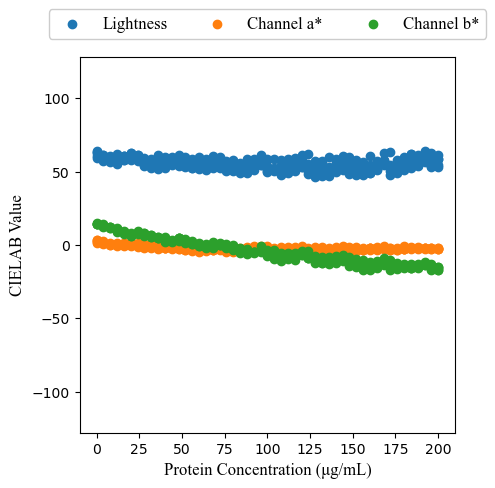

In [22]:
# Create subplots
fig, axs = plt.subplots(figsize=FIGURE_SIZE)

# Plot Label vs Lightness
axs.scatter(labels, lightness_reference, label='Lightness')
axs.set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
axs.set_ylabel('CIELAB Value', **AXIS_FONT)
axs.set_ylim([-128, 128])

# Plot Label vs Channel a*
axs.scatter(labels, a_reference, label='Channel a*')

# Plot Label vs Channel b*
axs.scatter(labels, b_reference, label='Channel b*')

if TITLE_DISPLAY == True:
    axs.set_title(f'{NAME_OF_LABEL} vs CIELAB', **TITLE_FONT)

# Add legend to the plot
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), prop=LEGEND_FONT, framealpha=1, ncol=3)

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Overview_of_Dataset_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

## 4.2. Plot each feature

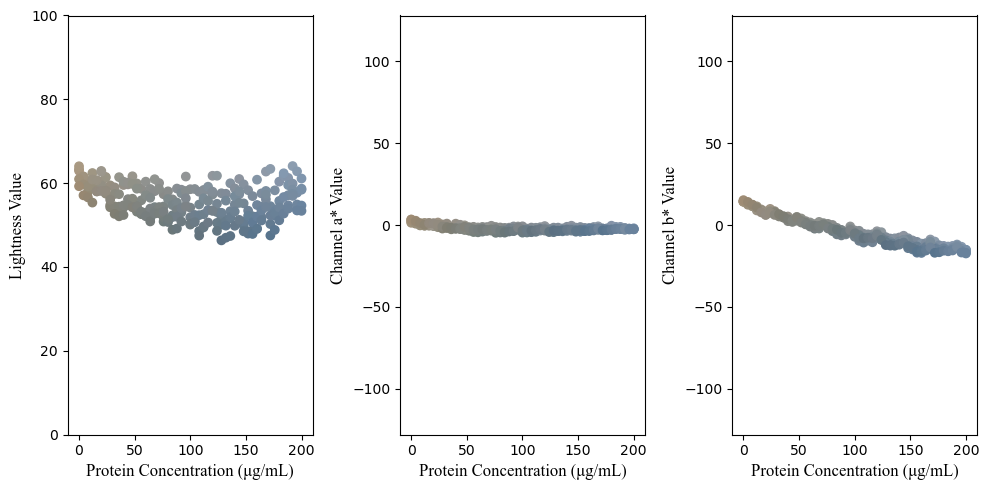

In [23]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(FIGURE_SIZE[0]*2, FIGURE_SIZE[1]))

# Plot Label vs Lightness
axs[0].scatter(labels, lightness_reference, color=colors)
axs[0].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
axs[0].set_ylabel('Lightness Value', **AXIS_FONT)
axs[0].set_ylim([0, 100])
if TITLE_DISPLAY == True:
    axs[0].set_title(f'{NAME_OF_LABEL} vs Lightness', **TITLE_FONT)

# Plot Label vs Channel a*
axs[1].scatter(labels, a_reference, color=colors)
axs[1].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
axs[1].set_ylabel('Channel a* Value', **AXIS_FONT)
axs[1].set_ylim([-128, 128])
if TITLE_DISPLAY == True:
    axs[1].set_title(f'{NAME_OF_LABEL} vs Channel a*', **TITLE_FONT)

# Plot Label vs Channel b*
axs[2].scatter(labels, b_reference, color=colors)
axs[2].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
axs[2].set_ylabel('Channel b* Value', **AXIS_FONT)
axs[2].set_ylim([-128, 128])
if TITLE_DISPLAY == True:
    axs[2].set_title(f'{NAME_OF_LABEL} vs Channel b*', **TITLE_FONT)

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Each_Channel_of_Dataset_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

# 5. Train and evaluate models

In [24]:
# Models and their names
models = {
    "random_forest": ensemble.RandomForestRegressor(),
    "gradient_boosting": ensemble.GradientBoostingRegressor(),
    "svm": svm.SVR(),
    "mlp": neural_network.MLPRegressor()
}

# Define the parameter grids for each model
param_grids = {
    "random_forest": {
        "n_estimators": [500, 1000, 2000],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
    },
    "gradient_boosting": {
        "n_estimators": [500, 1000, 2000],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
    },
    "svm": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto", 0.1, 1],
    },
    "mlp": {
        "hidden_layer_sizes": [(50, 30), (100, 50), (200, 100)],
        "activation": ["relu", "tanh"],
    },
}

# DataFrame to hold the results
results = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE"])

# Train, save, and evaluate each model
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    # Get the best parameters and score
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")
    
    # Update the model with the best parameters
    best_model = grid_search.best_estimator_
    model_name = f"{model_name}_{COLORIMETRY_SYSTEM}"
    Y_pred, mae, mse, rmse, r2 = train_save_evaluate_model(best_model, X_train, Y_train, X_test, Y_test, model_name, DATA_DIRECTORY)
    temp_df = pd.DataFrame({"Model": [model_name], "MAE": [mae], "MSE": [mse], "RMSE": [rmse], "R^2": [r2]})
    results = pd.concat([results, temp_df])

Best parameters for random_forest: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 1000}
Best score for random_forest: 0.9722275042086036
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\random_forest_lab.joblib
Best parameters for gradient_boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best score for gradient_boosting: 0.9696495478830732
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\gradient_boosting_lab.joblib
Best parameters for svm: {'C': 10, 'gamma': 'scale'}
Best score for svm: 0.9059357365542695
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\svm_lab.joblib
Best parameters for mlp: {'activation': 'relu', 'hidden_layer_sizes': (200, 100)}
Best score for mlp: 0.9634000221650382
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\mlp_lab.joblib


In [25]:
# Save the metrics to a .csv file
save_metrics_to_csv(results, METRIC_RESULT_FILE, DATA_DIRECTORY)
results.head(5)

Metrics saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\metrics\metrics_lab_Bradford-200uL-2.csv


,Model,MAE,MSE,RMSE,R^2
0,random_forest_lab,7.497603,93.510762,9.670096,0.959227
0,gradient_boosting_lab,7.601610,92.598807,9.622827,0.959625
0,svm_lab,8.690862,147.183263,12.131911,0.935824
0,mlp_lab,8.396298,114.460515,10.698622,0.950092


# 6. Load models and predict

In [26]:
# Initialize DataFrame to store predictions
predictions_df = pd.DataFrame()
predictions_df['CIELAB'] = list(X_test)  # Converting X_test to list
predictions_df['RGB'] = predictions_df['CIELAB'].apply(lambda lab: lab_to_rgb(*lab)) # Convert HSL back to RGB
predictions_df['color'] = predictions_df['RGB'].apply(lambda rgb: rgb_to_hex(*rgb))
predictions_df['y_test'] = Y_test

# Model names
model_names = list(models.keys())
model_names = [f"{name}_{COLORIMETRY_SYSTEM}" for name in model_names]
model_names_string = ["Random Forest", "Gradient Boosting", "SVM", "MLP"]

# Load each model, generate predictions and save to DataFrame
for model_name in model_names:
    model = load_model(model_name, DATA_DIRECTORY)
    if model is not None:
        predictions_df[model_name] = model.predict(X_test)

# Sort DataFrame by 'y_test' in ascending order
predictions_df = predictions_df.sort_values(by='y_test', ascending=True)

# Reset the index of the DataFrame
predictions_df.reset_index(drop=True, inplace=True)

Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\random_forest_lab.joblib
Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\gradient_boosting_lab.joblib
Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\svm_lab.joblib
Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.1\data\models\mlp_lab.joblib


# 7. Visualize

In [27]:
SAVE_FIGURE = False

## 7.1. Plot predictions

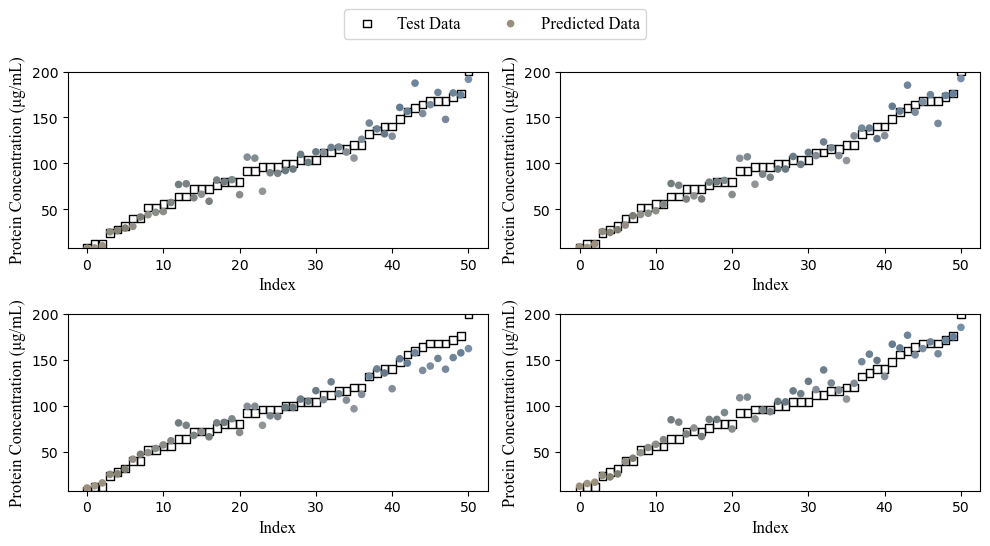

In [28]:
global_min = np.min([predictions_df[model].min() for model in model_names])
global_max = np.max([predictions_df[model].max() for model in model_names])
global_min = min(global_min, predictions_df['y_test'].min())
global_max = max(global_max, predictions_df['y_test'].max())

# Create a scatter plot for each model's predictions
fig, axes = plt.subplots(2, 2, figsize=(FIGURE_SIZE[0]*2, FIGURE_SIZE[1]))
axes = axes.ravel()

for i, model_name in enumerate(model_names):
    axes[i].scatter(predictions_df.index, predictions_df['y_test'], facecolors='none', edgecolors='black', s=30, marker='s', label='Test Data' if i == 0 else "")
    axes[i].scatter(predictions_df.index, predictions_df[model_name], c=predictions_df['color'], edgecolors='none', s=30, label='Predicted Data' if i == 0 else "")
    if TITLE_DISPLAY == True:
        axes[i].set_title(model_names_string[i], **TITLE_FONT)  # Fixed the model_names_string indexing
    axes[i].set_xlabel('Index', **AXIS_FONT)
    axes[i].set_ylabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
    axes[i].set_ylim([global_min, global_max])

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, prop=LEGEND_FONT, bbox_to_anchor=(0.5, 1.10))

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Predictions_of_Each_Model_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

## 7.2. Plot residuals

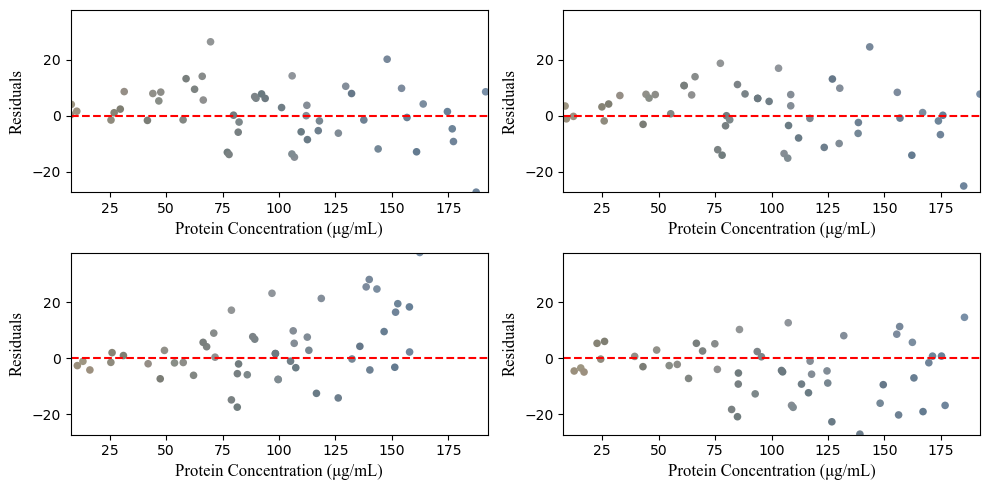

In [29]:
# Get global min and max of predicted values and residuals for all models
global_min_x = np.min([predictions_df[model].min() for model in model_names])
global_max_x = np.max([predictions_df[model].max() for model in model_names])

global_min_y = np.min([(predictions_df['y_test'] - predictions_df[model]).min() for model in model_names])
global_max_y = np.max([(predictions_df['y_test'] - predictions_df[model]).max() for model in model_names])

# Create a residual plot for each model's predictions
fig, axes = plt.subplots(2, 2, figsize=(FIGURE_SIZE[0]*2, FIGURE_SIZE[1]))
axes = axes.ravel()

for i, model_name in enumerate(model_names):
    residuals = predictions_df['y_test'] - predictions_df[model_name]
    axes[i].scatter(predictions_df[model_name], residuals, c=predictions_df['color'], edgecolors='none', s=30)
    if TITLE_DISPLAY == True:
        axes[i].set_title(model_names_string, **TITLE_FONT)
    axes[i].set_xlabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
    axes[i].set_ylabel('Residuals', **AXIS_FONT)
    axes[i].axhline(y=0, color='r', linestyle='--')  # Draw a horizontal line at y=0
    axes[i].set_xlim([global_min_x, global_max_x])
    axes[i].set_ylim([global_min_y, global_max_y])

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Residual_of_Predictions_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)

## 7.3. Plot overall predictions

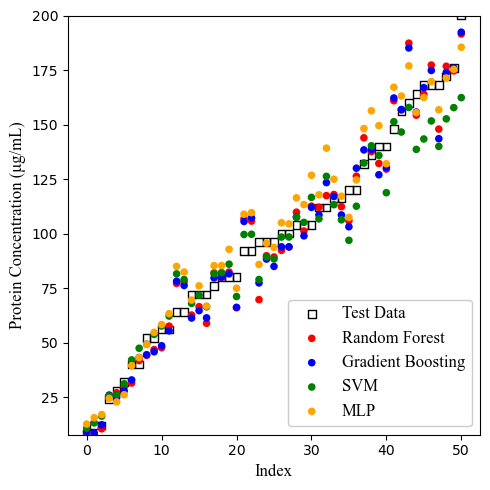

In [30]:
# Create a scatter plot for each model's predictions
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

# Define a list of colors for the models
colors = ['red', 'blue', 'green', 'orange']

# Scatter plot for y_test
ax.scatter(predictions_df.index, predictions_df['y_test'], facecolors='none', edgecolors='black', s=30, marker='s', label='Test Data')

# Looping over models to plot them
for model_key, model_name_str, color in zip(model_names, model_names_string, colors):
    ax.scatter(predictions_df.index, predictions_df[model_key], color=color, edgecolors='none', s=30, label=model_name_str)

if TITLE_DISPLAY == True:
    ax.set_title(f'Predicted {NAME_OF_LABEL} by different models', **TITLE_FONT)
ax.set_xlabel('Index', **AXIS_FONT)
ax.set_ylabel(f"{NAME_OF_LABEL} ({LABEL_UNIT})", **AXIS_FONT)
ax.set_ylim([global_min, global_max])
ax.legend(loc='lower right', prop=LEGEND_FONT, framealpha=1)

# Display the plots
plt.tight_layout()
plt.show()

# Save figure
if SAVE_FIGURE == True:
    save_fig(fig, f"Overview_of_Predictions_{COLORIMETRY_SYSTEM}", DATASET_NAME, DOCUMENT_DIRECTORY)